# MachadoBot - RNN Model training
- By Marcelo Rovai @Sept24
- With support from **Claude 3.5 Sonnet** and **ChatGPT 4o**

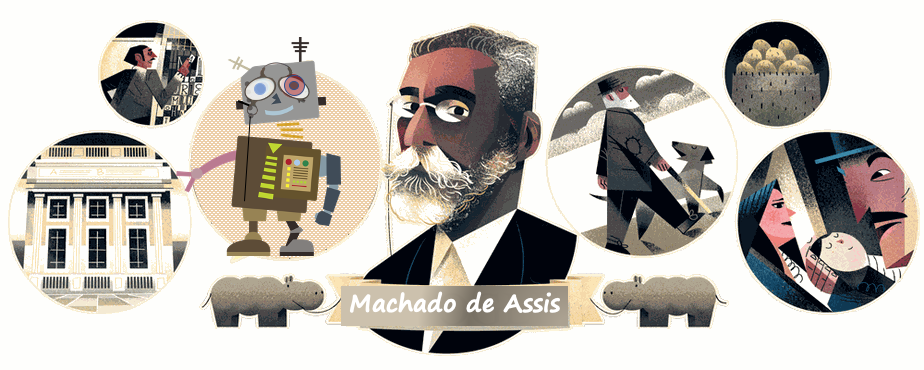

In this notebook, we have the main steps involved in developing and training a character-level language model based on Machado de Assis's books. The steps form the basis of understanding and presenting large language models (LLMs) using a simpler example of Machado de Assis text generation.



- The Artificial network developed on this project, generates text, character by character. Please see this following site, for a great general visual explanation, see from Andrej Karpathy, [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

## Main Libraries



In [31]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.saving import register_keras_serializable

## Data Preparation
   - **Task**: Gather and preprocess the data.
     - **Example**: For the Machado de Assis text generation, we collect works like *Dom Casmurro* and *Memórias Póstumas de Brás Cubas*, totaling **2,418,451 characters**. The text is processed by removing irrelevant characters (e.g., line breaks or non-standard symbols) and converting it into a format suitable for machine learning.
   - **Key Considerations**: Data cleaning is crucial, and you ensure the text is structured for analysis.

- Machado de Assis original XIX century books can be downloaded from: [Gutenberg Project](https://www.gutenberg.org/)

In [2]:
path = './machado/'

In [5]:
ls ./machado/

casmurro.txt  esau_jacob.txt  mao_luva.txt  memorial.txt  memorias.txt  papeis.txt  quincas.txt


In [6]:
# Read all the text files
file_names = ['casmurro.txt', 'esau_jacob.txt', 'mao_luva.txt', 'memorial.txt', 'memorias.txt', 'papeis.txt', 'quincas.txt']
text = ""
for file in file_names:
    with open(path+file, 'r', encoding='utf-8') as f:
        text += f.read()

print(f"Total characters: {len(text)}")

Total characters: 2418451


In [7]:
text[:150]

'DOM CASMURRO\n\nI\n\nDo titulo.\n\nUma noite destas, vindo da cidade para o Engenho Novo, encontrei no\ntrem da Central um rapaz aqui do bairro, que eu conhe'

### Tokenization and Vocabulary
   - **Task**: Convert the text into tokens.
     - **Example**: In this case, we will use **character-level tokenization**, where each unique character from the text becomes a part of the vocabulary. The vocabulary contained **117 unique characters**.
     - **Mapping**: Each character is assigned an index (e.g., 'A' → 65).
     - **Importance**: Tokenization allows the model to process text efficiently, turning the text into numerical data that it can understand and learn from.
     - **Example of mapping**: `"A Luva"` → `[65, 32, 76, 117, 118, 97]`

In [8]:
# Create vocabulary of unique characters
vocab = sorted(set(text))
print(f"Unique characters: {len(vocab)}")

Unique characters: 117


In [9]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [10]:
idx2char

array(['\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', '+', ',', '-',
       '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
       '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
       'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
       'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y', 'z', '§', '«', '°', '»', 'À', 'Á', 'Ã', 'Ç',
       'É', 'Ê', 'Í', 'Ó', 'Ú', 'à', 'á', 'â', 'ã', 'æ', 'ç', 'è', 'é',
       'ê', 'í', 'î', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ú', 'û', 'œ', '—', '’'],
      dtype='<U1')

In [11]:
# Convert text to integer representation
text_as_int = np.array([char2idx[c] for c in text])

In [12]:
text_as_int[:150]

array([31, 42, 40,  1, 30, 28, 46, 40, 48, 45, 45, 42,  0,  0, 36,  0,  0,
       31, 71,  1, 76, 65, 76, 77, 68, 71, 13,  0,  0, 48, 69, 57,  1, 70,
       71, 65, 76, 61,  1, 60, 61, 75, 76, 57, 75, 11,  1, 78, 65, 70, 60,
       71,  1, 60, 57,  1, 59, 65, 60, 57, 60, 61,  1, 72, 57, 74, 57,  1,
       71,  1, 32, 70, 63, 61, 70, 64, 71,  1, 41, 71, 78, 71, 11,  1, 61,
       70, 59, 71, 70, 76, 74, 61, 65,  1, 70, 71,  0, 76, 74, 61, 69,  1,
       60, 57,  1, 30, 61, 70, 76, 74, 57, 68,  1, 77, 69,  1, 74, 57, 72,
       57, 82,  1, 57, 73, 77, 65,  1, 60, 71,  1, 58, 57, 65, 74, 74, 71,
       11,  1, 73, 77, 61,  1, 61, 77,  1, 59, 71, 70, 64, 61])

### Training Sequences

Overall what we are trying to achieve is to have the model predict the next highest probability character given a historical sequence of characters. Its up to us (the user) to choose how long that historic sequence. Too short a sequence and we don't have enough information (e.g. given the letter "a" , what is the next character) , too long a sequence and training will take too long and most likely overfit to sequence characters that are irrelevant to characters farther out. While there is no correct sequence length choice, you should consider the text itself, how long normal phrases are in it, and a reasonable idea of what characters/words are relevant to each other.

The actual text data will be the text sequence shifted one character forward. For example:

Sequence In: "Hello my nam"
Sequence Out: "ello my name"


We can use the `tf.data.Dataset.from_tensor_slices` function to convert a text vector into a stream of character indices.

In [13]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [14]:
seq_length = 150
examples_per_epoch = len(text_as_int) // seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

print("Data preparation completed.")

Data preparation completed.


Using a `seq_length` of 150 provides the context for the model to learn from (around one paragraph).

Now, let's discuss the parameters:

1. `seq_length = 150`: It means each training example will consist of 150 characters, and the model will try to predict the 151st character.

2. `BUFFER_SIZE`: This to be the number of unique sequences in the dataset.

3. `BATCH_SIZE = 64`: This is generally a good default value. It's large enough to take advantage of vectorization but small enough to fit in memory on most systems. We can adjust this based on your available memory and processing power. If we have a GPU with more memory, you might increase this to 128 or 256.

4. `prefetch(tf.data.experimental.AUTOTUNE)`: It allows TensorFlow to automatically tune the prefetch buffer size.




## Model Creation

Parameters to consider when we move to model creation and training:

- `embedding_dim`: This is set to 256, which is usually sufficient, but we can increase it to 512 if we want to capture more nuanced relationships between characters.

- `rnn_neurons`: This was set to 1024, which is a good value for a dataset of our size. We can experiment with 512 or 2048 to see if it affects the quality of our generated text.

### Embedding
   - **Task**: Represent each token as a dense vector.
     - **Example**: After tokenization, each character is converted into a 256-dimensional vector using an **embedding layer**.
     - **Explanation**: The embedding captures relationships between characters. For example, similar characters may have embeddings that are closer in vector space.
     - **Visualization**: A 2D projection of these vectors using techniques like t-SNE can help illustrate how the characters are related.

### Model Architecture
   - **Task**: Build the model.
     - **Example**: We will construct a sequential model with three layers:
       1. **Embedding layer**: Transforms characters into dense vectors.
       2. **GRU (Gated Recurrent Unit)** layer: Handles sequences of tokens and learns from context. We use **1024 units** to capture long-term dependencies in the text.
       3. **Dense layer**: Outputs probabilities for each character in the vocabulary.
     - **Importance**: The GRU layer helps in learning sequential patterns in the text, which is critical for generating coherent text based on previous characters.

---

In [32]:
@register_keras_serializable()
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

In [15]:
def sparse_cat_loss(y_true, y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

def create_model(vocab_size, embed_dim, rnn_neurons):
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=None),  # Flexible input length
        GRU(rnn_neurons, return_sequences=True, recurrent_initializer='glorot_uniform'),
        Dense(vocab_size)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=sparse_cat_loss)
    return model

In [16]:
# Set up parameters
vocab_size = len(vocab)
embed_dim = 256
rnn_neurons = 1024

model = create_model(vocab_size, embed_dim, rnn_neurons)

# Build the model with a sample input shape
sample_input = tf.zeros((1, seq_length))
model(sample_input)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 150, 256)               │          29,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (1, 150, 1024)              │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 150, 117)               │         119,925 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,088,181 (15.60 MB)

 Trainable params: 4,088,181 (15.60 MB)

 Non-trainable params: 0 (0.00 B)

## Training


   - **Task**: Train the model using a loss function and optimizer.
     - **Example**:
       - **Loss Function**: Sparse Categorical Crossentropy, which compares the model’s predictions with the actual next character.
       - **Optimizer**: Adam (a widely used optimizer for deep learning).
       - **Epochs**: 50 training cycles with a **batch size** of 64 were used.
     - **Monitoring**: We monitore loss reduction over epochs, and observed a steady decrease from 2.88 to 0.45 across 50 epochs.
     - **Visual**: Show a loss curve to demonstrate how the model improves over time.


In [25]:
# Training
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_callback = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='loss')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(dataset, epochs=50, callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - loss: 2.8657 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 1.7488 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 1.4776 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 1.3678 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 1.3007 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 1.2552 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 1.2212 - learning_rate: 0.0010
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 1.1873 - learning_rate: 0.0010
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 1.1597 - learning_rate: 0.0010
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 1.1300 - learning_rate: 0.0010
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 1.1065

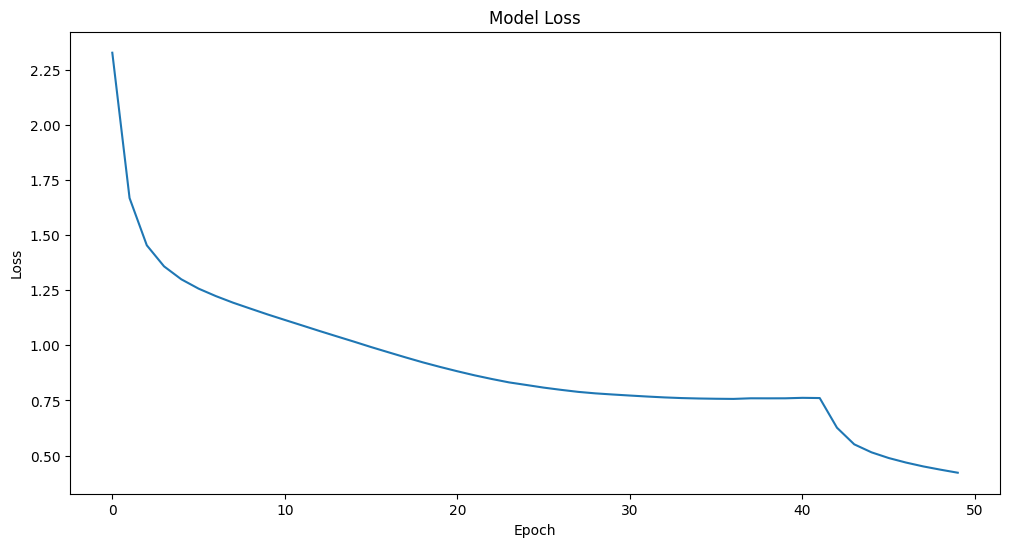

In [26]:
# Plot the training curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [33]:
model.save('my_rnn_model.keras', save_format='keras')

In [34]:
loaded_model = load_model('my_rnn_model.keras', custom_objects={'sparse_cat_loss': sparse_cat_loss})

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [52]:
# Save weights
model.save_weights('my_rnn_weights.weights.h5')

In [49]:
# Save the model
tf.saved_model.save(model, 'my_saved_model')

# To load later
loaded_model = tf.saved_model.load('my_saved_model')

In [50]:
loaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7dc89c7469b0>

## Text Generation

 - **Task**: Generate text using the trained model.
     - **Example**: Start with a seed text like "A Luva" and generate subsequent characters one by one. We introduce **temperature** to control the creativity of the output:
       - **Low temperature (0.5)**: More predictable and conservative text.
       - **Medium temperature (0.7)**: Balanced generation.
       - **High temperature (1.0)**: More random, sometimes incoherent output.
     - **Example Output**: We generate text samples with different temperatures to illustrate how varying the temperature influences the creativity of the output.

In [35]:
def generate_text(model, start_string, char2idx, idx2char, num_generate=1000, temperature=0.7):
    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    for i in range(num_generate):
        predictions = model(input_eval)
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Append the predicted character to the input for the next iteration
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], axis=-1)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))



In [36]:
# Generate text with different temperatures
temperatures = [0.5, 0.7, 1.0]

for temp in temperatures:
    print(f"\nGenerated text with temperature {temp}:\n")
    generated_text = generate_text(model, "A LUVA DE CASMURRO ",
                                   char2idx, idx2char,
                                   num_generate=2000,
                                   temperature=temp)
    print(generated_text)
    print("-" * 50)


Generated text with temperature 0.5:

A LUVA DE CASMURRO ANES


A NOR O ESPELED


ESAÚ TORBE


A Visto e do punho esquece da minha cabeça de Plutarcho


Furão. Então, um passaro, não sendo impossivel que a noite para os
vestia e descontamento de Rubião. Já então desceu, porém, que a tinha
ideia de menos chegar a casa, havia algum perigo; foi o que viu no
largo de S. Francisco de Pombal. Não pediu licença á casa do tio
Penunido e das suas esperanças todas. A qualquer que fosse, a
opinião de que elle tinha alguma intenção de intervallo, porque estava
encoberto por um pouco alvoroço. A manhã era agora sem estrepito, e
escreveu algumas lagrimas dos amigos, que ella escutava a tempo.




CAPITULO CXXXII


O proprio marido recebe ao patamar da mesma carta de Maria
Benedicta.

--Pois vae comprar bilhete, emendou D. Carmo ou a alguem; disse ella.

--Casarás, disse elle consentir em um comer divertido que eu.

--Tanta vez do meu systema, concluiu elle.

--Não escrevo isto por palavra. Um caso 

## Export model and training results to Drive

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [54]:
!scp -r /content/my_saved_model '/content/gdrive/MyDrive/LLMs/MachadoBot'

In [ ]:
!scp -r /content/machado '/content/gdrive/MyDrive/LLMs/MachadoBot/machado'
!scp -r /content/saved_model '/content/gdrive/MyDrive/LLMs/MachadoBot/saved_model'

## Challenges and Limitations
   - **Task**: Address the issues with the model.
     - **Example**:
       - **Limited context window**: The model only uses a fixed number of previous characters (150 in this case), limiting its ability to capture long-term dependencies in the text.
       - **Lack of coherence**: The model may generate grammatically correct text but struggle with maintaining a coherent narrative over long paragraphs.
     - **Character-level modeling**: Although character-level models work well, word-level tokenization could improve coherence and reduce complexity.

## Bridging to Modern LLMs
   - **Task**: Compare the simple model to modern LLMs.
     - **Example**:
       - **Scale**: Our character-level model (with **4 million parameters**) is small compared to models like GPT-3, which has **175 billion parameters**, or Llama 3.1 with its **405 billion parameter**.
       - **Architecture**: Modern models use the Transformer architecture, which excels in handling long-range dependencies.
       - **Tokenization**: Instead of characters, modern LLMs often use **subword tokenization**, which helps balance between handling rare words and common words more efficiently.
     - **Key Takeaway**: The step from a simple character-level model to a modern LLM involves improvements in scale, architecture, and tokenization.

### Future Directions
   - **Task**: Discuss improvements.
     - **Examples**:
       - **Word-level tokenization**: Shifting from characters to words or subwords.
       - **Attention mechanisms**: Introducing attention layers, which allow models to focus on important parts of the input sequence.
       - **Fine-tuning larger models**: Using pre-trained models for Portuguese, like **BERTimbau**, to fine-tune with specific literary styles.


## Embeddings Visualization

In [45]:
#char2idx = {u: i for i, u in enumerate(vocab)}  # vocabulary from tokenization
#idx2char = np.array(vocab)

# Extract the embeddings from the embedding layer of your trained model
embedding_layer = model.get_layer('embedding')
embedding_weights = embedding_layer.get_weights()[0]

print("Embedding shape:", embedding_weights.shape)  # Should print (vocab_size, embedding_dim)

Embedding shape: (117, 256)


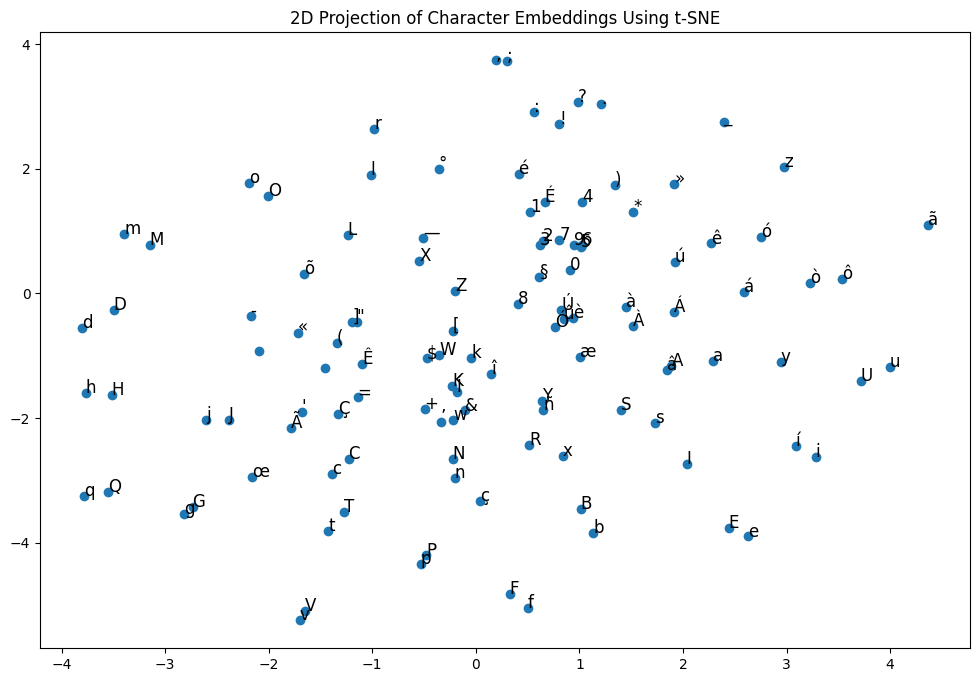

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding_weights)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])

# Annotate points with characters
for i, char in enumerate(idx2char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=12)

plt.title("2D Projection of Character Embeddings Using t-SNE")
plt.show()

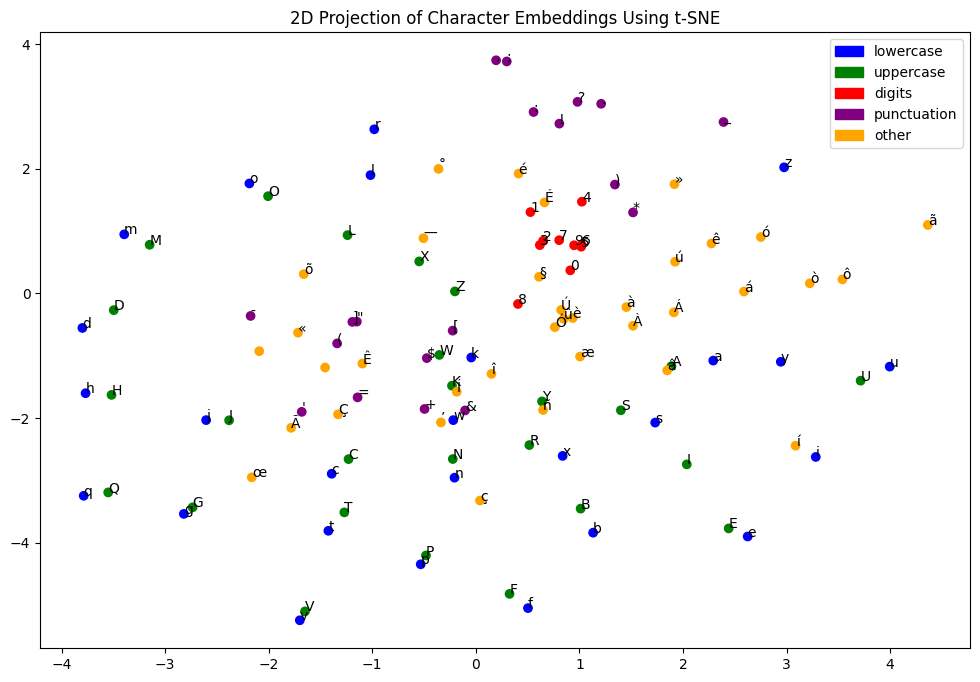

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in idx2char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)

# Annotate points with characters
for i, char in enumerate(idx2char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

plt.title("2D Projection of Character Embeddings Using t-SNE")
plt.show()


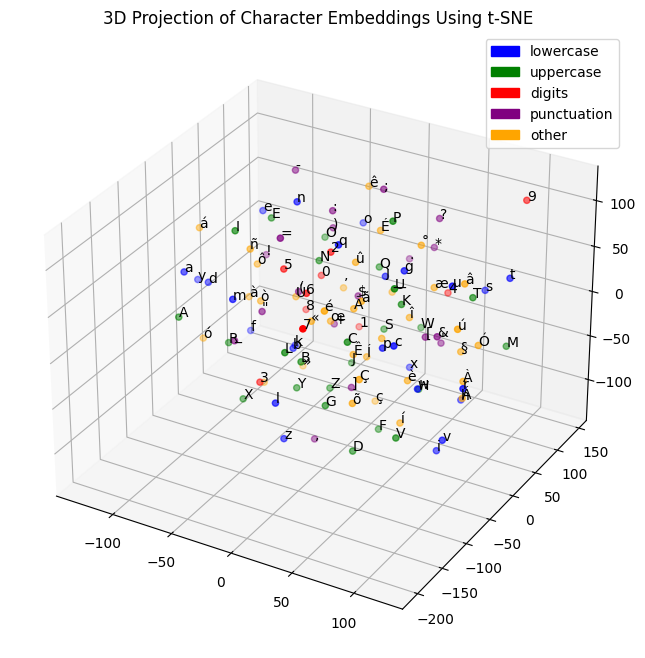

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string
from mpl_toolkits.mplot3d import Axes3D

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply t-SNE to the embeddings (now in 3D)
tsne = TSNE(n_components=3, random_state=42)
embedding_3d = tsne.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in idx2char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=colors)

# Annotate points with characters
for i, char in enumerate(idx2char):
    ax.text(embedding_3d[i, 0], embedding_3d[i, 1], embedding_3d[i, 2], char, fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

ax.set_title("3D Projection of Character Embeddings Using t-SNE")
plt.show()


In [42]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


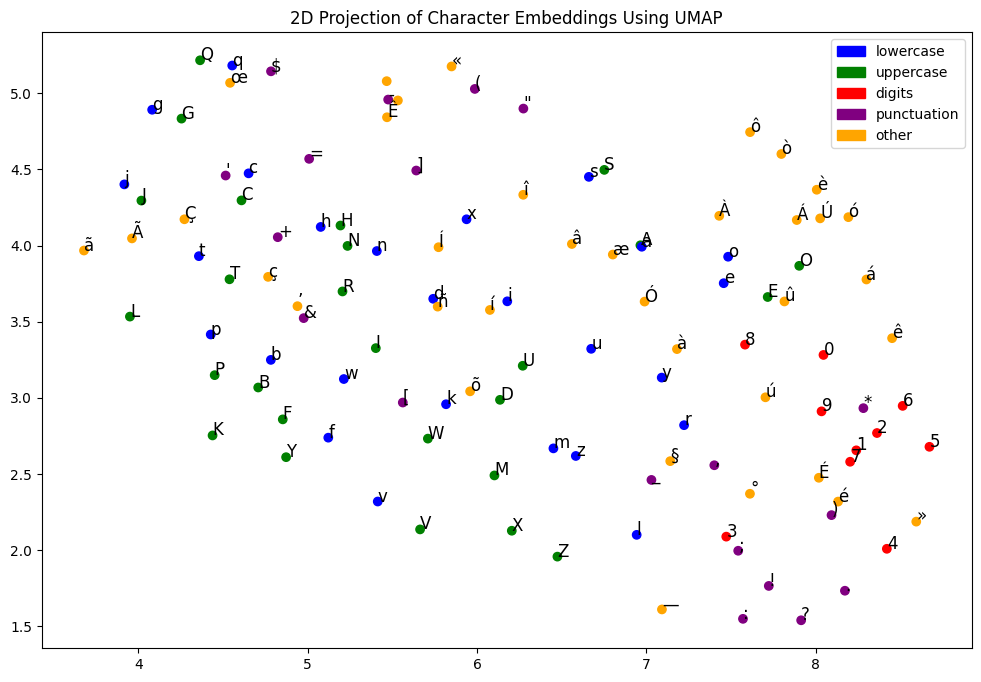

In [43]:
import umap
import matplotlib.pyplot as plt
import string

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply UMAP to the embeddings (for 2D projection)
umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in idx2char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Plot the 2D UMAP projection
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)

# Annotate points with characters
for i, char in enumerate(idx2char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=12)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

plt.title("2D Projection of Character Embeddings Using UMAP")
plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


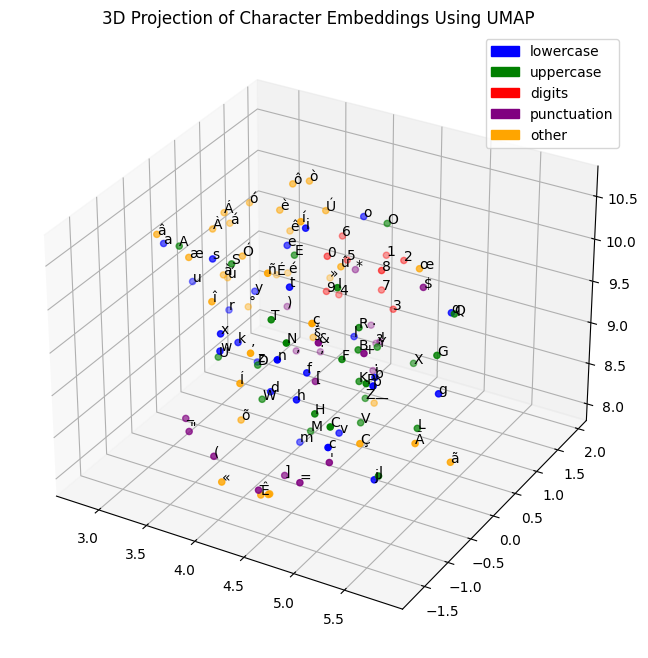

In [44]:
import umap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import string

# Apply UMAP to the embeddings (for 3D projection)
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in idx2char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=colors)

# Annotate points with characters
for i, char in enumerate(idx2char):
    ax.text(embedding_3d[i, 0], embedding_3d[i, 1], embedding_3d[i, 2], char, fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

ax.set_title("3D Projection of Character Embeddings Using UMAP")
plt.show()
